In [1]:
# Import of the necessary python libraries
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt

C:\Users\henri\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Define the risk-free rate rf for the calculation (for calculation of rf see the Excel tables)
rf = 0.003

In [3]:
# Creating a list-variable for the chosen indices
symbols = ['^STOXX50E','^DJI','^N225']
noa = len(symbols)

In [4]:
# Import of financial data from Yahoo Finance
prices = pd.DataFrame()
for sym in symbols:
    prices[sym] = web.DataReader(sym, data_source='yahoo',start='01/10/2019',end ='19/06/2020')['Adj Close']
prices = prices.dropna()
prices.head()

,^STOXX50E,^DJI,^N225
Date,,,
2019-01-10,3075.729980,24001.919922,20163.800781
2019-01-11,3070.040039,23995.949219,20359.699219
2019-01-16,3077.219971,24207.160156,20442.750000
2019-01-17,3069.350098,24370.099609,20402.269531
2019-01-18,3134.919922,24706.349609,20666.070312


In [5]:
# Calculating the Covariance-Matrix of the chosen indices
cov_matrix = prices.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,^STOXX50E,^DJI,^N225
^STOXX50E,0.000301,0.000271,0.000134
^DJI,0.000271,0.000429,0.000106
^N225,0.000134,0.000106,0.000215


In [6]:
# Calculating the expected return of the chosen indices ex post
e_r = prices.resample("D").last().pct_change().mean()*181
e_r

^STOXX50E    0.037363
^DJI         0.049204
^N225        0.049244
dtype: float64

In [7]:
# Calculating the standard diviation / volatility of the chosen indices
sd = prices.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(181))
sd

^STOXX50E    0.233560
^DJI         0.278723
^N225        0.197433
dtype: float64

In [8]:
# Concatenation of the indices and the returns/volatility
assets = pd.concat([e_r, sd], axis=1)
assets.columns = ["Returns", "Volatility"]
assets

,Returns,Volatility
^STOXX50E,0.037363,0.233560
^DJI,0.049204,0.278723
^N225,0.049244,0.197433


In [9]:
# Creating blanco lists for the portfolio return, portfolio volatility and the weights of the particular indices
# In addition, setting the number of determined portfolios to 2500 --> Law of large numbers
p_ret = []
p_vol = []
p_weights = []

num_assets = len(prices.columns)
num_portfolios = 2500

In [10]:
# Calculation of the weights of the particular indices by frequently random
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, e_r)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    p_vol.append(ann_sd)

In [11]:
# Return and Volatility Variables for plotting the portfolios
port_ret = np.array(p_ret)
port_vol = np.array(p_vol)

In [12]:
data = {"Returns": p_ret, "Volatility": p_vol}

In [13]:
for counter, symbol in enumerate(prices.columns.tolist()):
    data[symbol+" weight"] = [w[counter] for w in p_weights]

In [14]:
portfolios = pd.DataFrame(data)

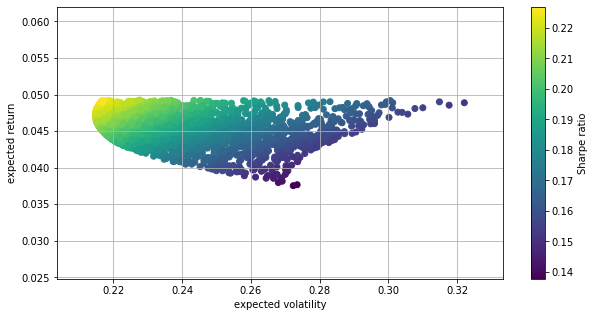

In [22]:
# Plotting the 2500 calculated portfolios and the Sharpe ratio in the colorbar
plt.figure(figsize=(10, 5))
plt.scatter(port_vol,port_ret,c=port_ret/port_vol, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [16]:
# Summary of the MVP with Return, Volatility and the particular weights
min_var_port = portfolios.iloc[portfolios["Volatility"].idxmin()]
min_var_port

Returns             0.047059
Volatility          0.214786
^STOXX50E weight    0.183465
^DJI weight         0.146919
^N225 weight        0.669616
Name: 1119, dtype: float64

In [17]:
sharpe_ratio_mvp = (min_var_port["Returns"] - rf) / min_var_port["Volatility"]
sharpe_ratio_mvp

0.2051284626264086

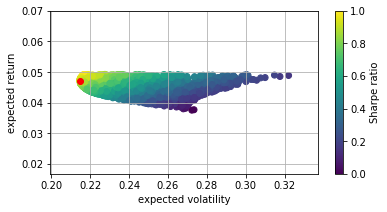

In [18]:
# Visualization of the MVP into the portfolio figure with a red point
plt.subplots(figsize=(6,3))
plt.scatter(portfolios["Volatility"], portfolios["Returns"], c = portfolios["Returns"]/portfolios["Volatility"])
plt.scatter(min_var_port[1], min_var_port[0], color="r")
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [19]:
# The portfolio with the maximum sharpe ratio is saved in the variable optimal_risky_portfolio and the summary is shown below
optimal_risky_portfolio = portfolios.iloc[((portfolios["Returns"]-rf)/portfolios["Volatility"]).idxmax()]
optimal_risky_portfolio

Returns             0.049156
Volatility          0.216702
^STOXX50E weight    0.006668
^DJI weight         0.225004
^N225 weight        0.768328
Name: 1439, dtype: float64

In [20]:
sharpe_ratio = (optimal_risky_portfolio["Returns"] - rf) / optimal_risky_portfolio["Volatility"]
sharpe_ratio

0.21299370079065685

C:\Users\henri\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  del sys.path[0]


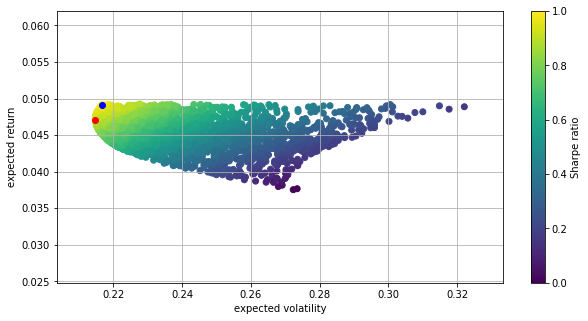

In [23]:
# Visualization of the optimal risky portfolio into the previous figure with a blue point
plt.subplots(figsize=(10,5))
plt.scatter(portfolios["Volatility"], portfolios["Returns"], c = portfolios["Returns"]/portfolios["Volatility"])
plt.scatter(min_var_port[1], min_var_port[0], color="r")
plt.scatter(optimal_risky_portfolio[1], optimal_risky_portfolio[0], color="b")
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
# Safe the figure to the computer (optional)
plt.savefig("port_dev_cor", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)